# Emotion Recognition and Analysis

## Introduction
This notebook aims to provide a comprehensive analysis of emotion recognition in text data. We'll compare and contrast the performance of neural network models with a vanilla bigram model. We'll also visualize the results to gain insights into model accuracy, generation, and prediction.

## Setup and Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from collections import Counter
from utils import LanguageModel
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [17]:
# load the test data
test = pd.read_csv('data/test.csv')

# load the tokenizer
with open('saved_models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# load the saved models
ffn_model = load_model('saved_models/ffn_model.h5')
rnn_model = load_model('saved_models/rnn_model.h5')
cnn_model = load_model('saved_models/cnn_model.h5')

EMOTION_KEY = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5: 'surprise'}

In [46]:
test

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0
...,...,...
1995,i just keep feeling like someone is being unki...,3
1996,im feeling a little cranky negative after this...,3
1997,i feel that i am useful to my people and that ...,1
1998,im feeling more comfortable with derby i feel ...,1


In [19]:
# prepare test data
X_test = tokenizer.texts_to_sequences(test['text'])
X_test = pad_sequences(X_test, maxlen=66, padding='post')
y_test = test['label'].values

# evaluate feed-forward neural network
ffn_loss, ffn_accuracy = ffn_model.evaluate(X_test, y_test, verbose=2)
print("Feed-Forward Neural Network - Test Loss:", ffn_loss, "Test Accuracy:", ffn_accuracy)

# evaluate recurrent neural network
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose=2)
print("Recurrent Neural Network - Test Loss:", rnn_loss, "Test Accuracy:", rnn_accuracy)

# evaluate convolutional neural network
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=2)
print("Convolutional Neural Network - Test Loss:", cnn_loss, "Test Accuracy:", cnn_accuracy)


# generate predictions
ffn_probabilities = ffn_model.predict(X_test)
rnn_probabilities = rnn_model.predict(X_test)
cnn_probabilities = cnn_model.predict(X_test)

# convert probabilities to predicted classes
ffn_predictions = np.argmax(ffn_probabilities, axis=1)
rnn_predictions = np.argmax(rnn_probabilities, axis=1)
cnn_predictions = np.argmax(cnn_probabilities, axis=1)
# classification Report
print("Feed-Forward Neural Network Classification Report:")
print(classification_report(y_test, ffn_predictions))

print("Recurrent Neural Network Classification Report:")
print(classification_report(y_test, rnn_predictions))

print("Convolutional Neural Network Classification Report:")
print(classification_report(y_test, cnn_predictions))

# confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

63/63 - 0s - loss: 2.2397 - accuracy: 0.1060 - 32ms/epoch - 506us/step
Feed-Forward Neural Network - Test Loss: 2.2396912574768066 Test Accuracy: 0.10599999874830246
63/63 - 0s - loss: 2.0991 - accuracy: 0.4215 - 353ms/epoch - 6ms/step
Recurrent Neural Network - Test Loss: 2.0991475582122803 Test Accuracy: 0.42149999737739563
63/63 - 0s - loss: 0.7935 - accuracy: 0.8600 - 66ms/epoch - 1ms/step
Convolutional Neural Network - Test Loss: 0.7934795618057251 Test Accuracy: 0.8600000143051147
63/63 [==============================] - 0s 868us/step
Feed-Forward Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.05      0.09       581
           1       0.35      0.12      0.18       695
           2       0.11      0.13      0.12       159
           3       0.10      0.08      0.09       275
           4       0.09      0.11      0.10       224
           5       0.03      0.48      0.06        66

    accuracy          

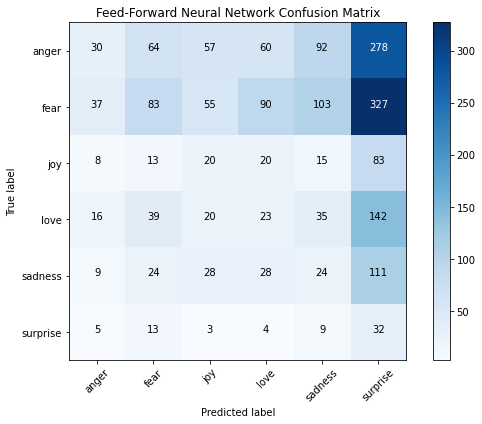

In [20]:
ffn_cm = confusion_matrix(y_test, ffn_predictions)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(ffn_cm, classes=EMOTION_KEY.values(), title='Feed-Forward Neural Network Confusion Matrix')

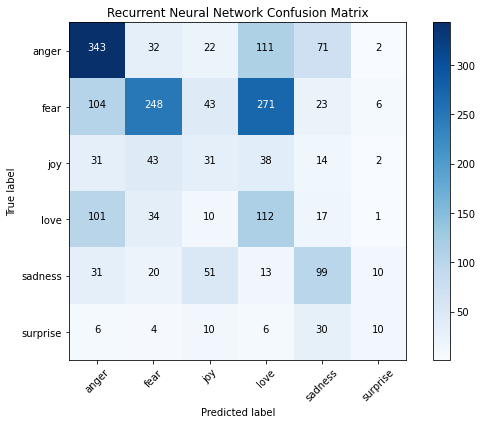

In [23]:
rnn_cm = confusion_matrix(y_test, rnn_predictions)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(rnn_cm, classes=EMOTION_KEY.values(), title='Recurrent Neural Network Confusion Matrix')

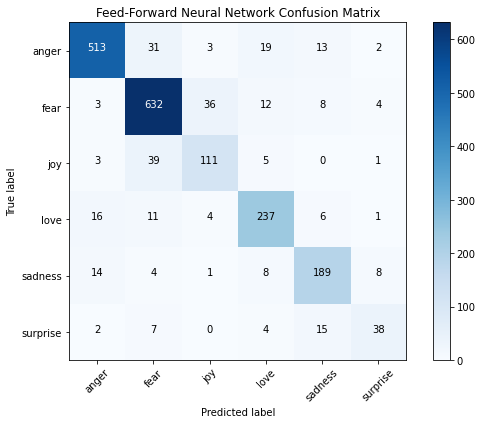

In [24]:
cnn_cm = confusion_matrix(y_test, cnn_predictions)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnn_cm, classes=EMOTION_KEY.values(), title='Feed-Forward Neural Network Confusion Matrix')

## Testing generated sentences

In [ ]:
# load the generated bigram sequences
with open('vanilla_emotion_results.txt', 'r') as file:
    bigram_gen = json.load(file)

In [47]:
# convert the generated sentences into the specified format
formatted_sentences = []
for emotion, sentences in bigram_gen.items():
    for sentence in sentences:
        # remove beginning and end sentence tokens
        sentence = [token for token in sentence if token not in ['<s>', '</s>']]
        formatted_sentence = ' '.join(sentence)
        formatted_sentences.append({'text': formatted_sentence, 'label': emotion})

# create a DataFrame from the formatted sentences
formatted_df = pd.DataFrame(formatted_sentences)

# save the DataFrame to a CSV file
formatted_df.to_csv('formatted_generated_sentences.csv', index=False)

In [60]:
bigen = pd.read_csv("formatted_generated_sentences.csv")
X_bigen = tokenizer.texts_to_sequences(bigen['text'])
X_bigen = pad_sequences(X_bigen, maxlen=66, padding='post')
y_bigen = bigen['label'].values

In [62]:
ffnloss, ffnaccuracy = ffn_model.evaluate(X_bigen, y_bigen, verbose=2)

2/2 - 0s - loss: 1.7933 - accuracy: 0.2000 - 20ms/epoch - 10ms/step


In [63]:
rnnloss, rnnaccuracy = rnn_model.evaluate(X_bigen, y_bigen, verbose=2)

2/2 - 0s - loss: 3.0998 - accuracy: 0.2500 - 34ms/epoch - 17ms/step


In [64]:
cnnloss, cnnaccuracy = cnn_model.evaluate(X_bigen, y_bigen, verbose=2)

2/2 - 0s - loss: 2.9908 - accuracy: 0.5667 - 21ms/epoch - 11ms/step
